# Identifying Entities in Healthcare Data

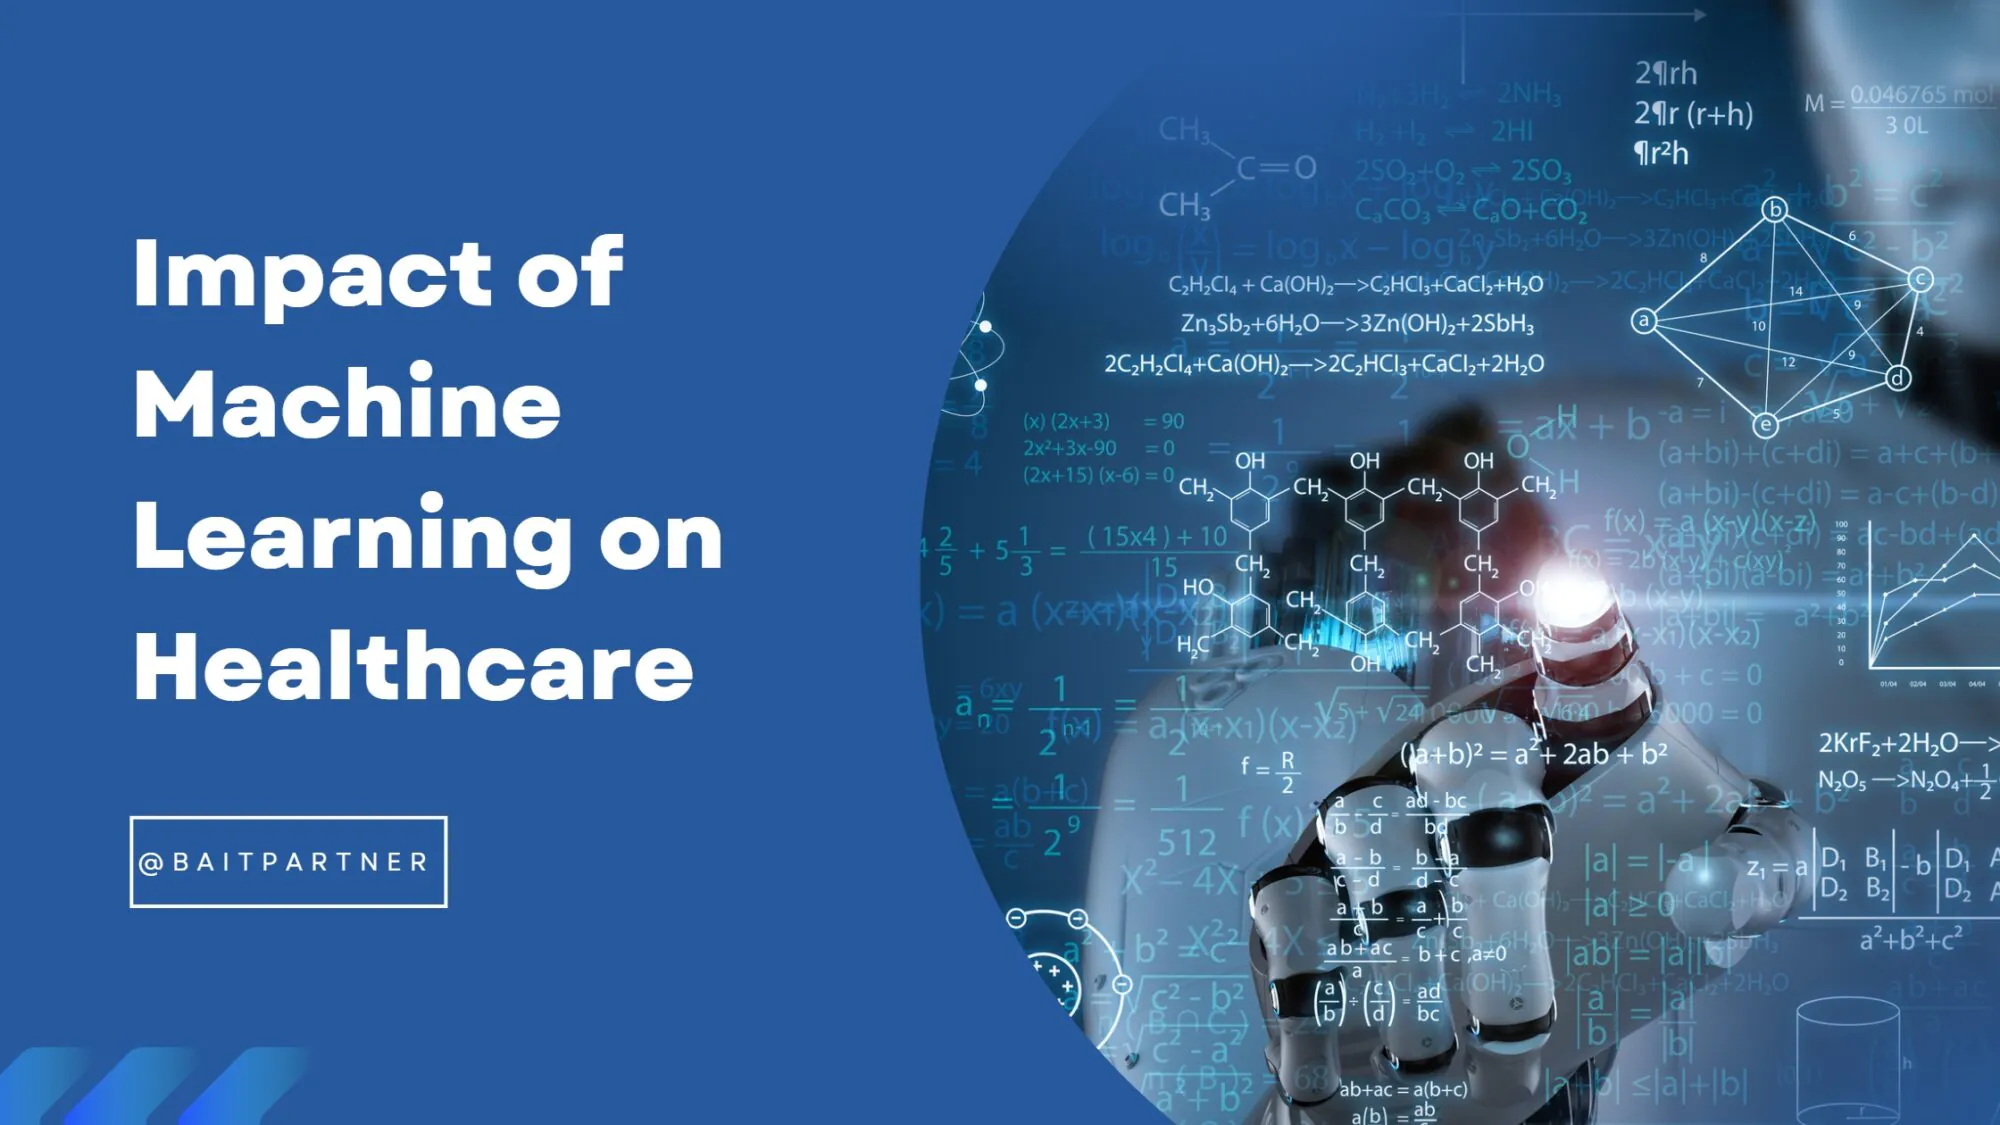

### Introduction to Project
We have data of a Healthcare company. Company aims to connect the medical communities with millions of patients across the country. 


Company has a web platform that allows doctors to list their services and manage patient interactions and provides services for patients such as booking interactions with doctors and ordering medicines online. Here, doctors can easily organise appointments, track past medical records and provide e-prescriptions.


So, company is providing medical services, prescriptions and online consultations and generating huge data day by day.


Let’s take a look at the following snippet of medical data that may be generated when a doctor is writing notes to his/her patient or as a review of a therapy that he or she has done.


“The patient was a 62-year-old man with squamous cell lung cancer, which was first successfully treated by a combination of radiation therapy and chemotherapy.”

 

As we can see in this text, a person with a non-medical background cannot understand the various medical terms. We have taken a simple sentence from a medical data set to understand the problem and where we can understand the terms ‘cancer’ and ‘chemotherapy’. 


We have been given such a data set in which a lot of text is written related to the medical domain. As we can see in the dataset, there are a lot of diseases that can be mentioned in the entire dataset and their related treatments are also mentioned implicitly in the text, which we saw in the aforementioned example that the disease mentioned is cancer and its treatment can be identified as chemotherapy using the sentence.


But, note that it is not explicitly mentioned in the dataset about the diseases and their treatment, but somehow, we can build an algorithm to map the diseases and their respective treatment.

We have been asked to determine the disease name and its probable treatment from the dataset and list it out in the form of a table.

There are four datasets to process, which are as follows:

- train_sent
- test_sent
- train_label
- test_label

We have the train and the test datasets; the train dataset is used to train the CRF model, and the test dataset is used to evaluate the built model. 
### Lets get going!!

### Workspace set up: Import and Install useful packages.

In [1]:
!pip install pycrf
!pip install sklearn-crfsuite

import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics

model = spacy.load("en_core_web_sm")
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

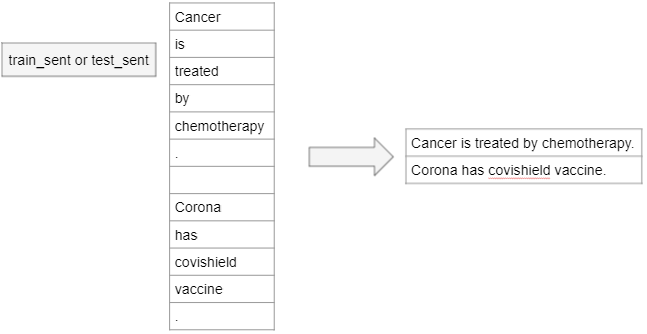

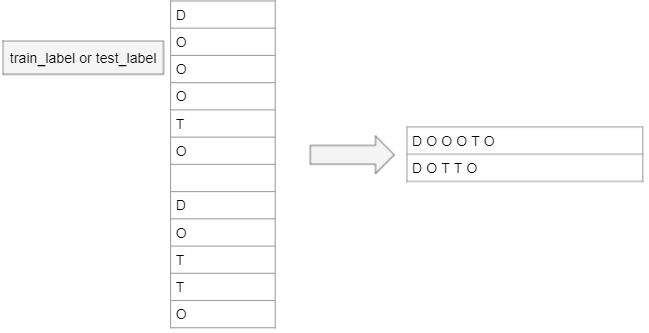

In [2]:
#Opening and saving data
with open('.....\train_sent','r') as train_sent_file:
    train_sentences=train_sent_file.readlines()
with open('......\test_sent','r') as test_sent_file:
    test_sentences=test_sent_file.readlines()
with open('......\train_label','r') as train_label_file:
    train_label=train_label_file.readlines()
with open('......\test_label','r') as test_label_file:
    test_label=test_label_file.readlines()

In [3]:
#Lets check first 5 words
train_sentences[0:5]

['All\n', 'live\n', 'births\n', '>\n', 'or\n']

\n is appearing at end of each entity probably due to line break after each entity in original file

In [4]:
#Lets remove \n using simple list comprehension
train_sentences_clean=[token.replace('\n','') for token in train_sentences]
test_sentences_clean=[token.replace('\n','') for token in test_sentences]
train_label_clean=[label.replace('\n','') for label in train_label]
test_label_clean=[label.replace('\n','') for label in test_label]

In [5]:
train_sentences_clean[0:5]

['All', 'live', 'births', '>', 'or']

In [6]:
#size of lable and sentence data base
print(len(train_sentences_clean))
print(len(test_sentences_clean))
print(len(train_label_clean))
print(len(test_label_clean))

48501
19674
48501
19674


In [7]:
# Lets define a function to get words senetnce wise with break at whitespace i.e. ''
def get_Sentences_or_Labels(sent_or_label_list):
    final_sent_label_clean=[]
    sentence_or_labels=[]
    for token_or_label in sent_or_label_list:
        if (token_or_label != ''):
            sentence_or_labels.append(token_or_label)
        else:
            final_sent_label_clean.append(sentence_or_labels)
            sentence_or_labels=[]
    return final_sent_label_clean

In [8]:
#Using fuction defined above
final_train_sentences_clean=get_Sentences_or_Labels(train_sentences_clean)
final_test_sentences_clean=get_Sentences_or_Labels(test_sentences_clean)
final_train_labels_clean=get_Sentences_or_Labels(train_label_clean)
final_test_labels_clean=get_Sentences_or_Labels(test_label_clean)

In [9]:
# Lets join all the words in individual sentences
all_train_sentence=[" ".join(tokens) for tokens in final_train_sentences_clean ]
all_test_sentence=[" ".join(tokens) for tokens in final_test_sentences_clean ]
all_train_labels=[" ".join(tokens) for tokens in final_train_labels_clean ]
all_test_labels=[" ".join(tokens) for tokens in final_test_labels_clean ]

### Count of number of sentences in the processed train and test dataset 

In [10]:
print(len(all_train_sentence))
print(len(all_test_sentence))

2599
1056


### Count of number of lines of labels in the processed train and test dataset.

In [11]:
print(len(all_train_labels))
print(len(all_test_labels))

2599
1056


## Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging. 



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [12]:
all_sentence=all_train_sentence+all_test_sentence
all_sentence[0:2]

['All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )',
 'The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )']

In [13]:
nouns_propn =[]
for sentence in all_sentence:
    processed_sentence=model(sentence)
    for token in processed_sentence:
        if (token.pos_ =='NOUN') or (token.pos_ =='PROPN'):
            nouns_propn.append(token.text)

### Print the top 25 most common tokens with NOUN or PROPN PoS tags

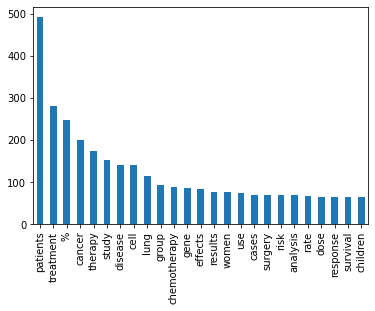

patients        492
treatment       281
%               247
cancer          200
therapy         175
study           154
disease         142
cell            140
lung            116
group            94
chemotherapy     88
gene             87
effects          85
results          77
women            77
use              75
cases            71
surgery          71
risk             71
analysis         70
rate             67
dose             66
response         66
survival         65
children         64
dtype: int64


In [14]:
nouns_propn_table=pd.Series(nouns_propn)
nouns_propn_table.value_counts()[:25].plot.bar()
plt.show()
print(nouns_propn_table.value_counts()[:25])

Among all the words in the sentence database as expected patient, treatment, and disease words are domintating

## Defining features for CRF





In [15]:
# Let's define the features to get the feature value for one word.
def featuresforWordsinSentence(sentences, pos, pos_tag):
    word= sentences[pos]
    features=[
        'word.lower=' + word.lower(),
        'word.pos='+ pos_tag[pos],
        'word[0].upper=%s' % word[0].isupper(),
        'worddigit=%s' %word.isdigit(),
        'word[-2:]='+ word[-2:],
        'word[-3:]='+ word[-3:],
        'word_upper=%s'% word.isupper()
    ]
    if (pos>0):
        word_prev=sentences[pos-1]
        features.extend([
            'word_prev.lower='+ word_prev.lower(),
            'word_prev.pos='+ pos_tag[pos-1],
            'word_prev1stlettercapitalupper=%s' % word_prev[0].isupper(),
            'word_prev_digit=%s' % word_prev.isdigit(),
            'word_prev_upper=%s'% word_prev.isupper()
       ]) 
    else:
       features.append('BEG') 
    if pos== (len(sentences)-1):
       features.append('END')
    return features

## Getting the features

### Write a code/function to get the features for a sentence

In [16]:
# Lets get features for a sentence.
def FeaturesForAllWords(sentence):
    processed_sentence= model(sentence)
    pos_tag=[]
    for token in processed_sentence:
        pos_tag.append(token.pos_)
    sentence_list=sentence.split()
    return [featuresforWordsinSentence(sentence_list, pos, pos_tag) for pos in range(len(sentence_list))]

### Write a code/function to get the labels of a sentence

In [17]:
# Lets get the labels for a sentence.
def LabelsForAllWords(labels):
    label=labels.split()
    return label

## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset 

In [18]:
from tqdm import tqdm

In [19]:
X_train=[FeaturesForAllWords(sentence) for sentence in tqdm(all_train_sentence)]

100%|█████████████████████████████████████████████████████████████████████████████| 2599/2599 [00:15<00:00, 164.82it/s]


In [20]:
X_test=[FeaturesForAllWords(sentence) for sentence in tqdm(all_test_sentence)]

100%|█████████████████████████████████████████████████████████████████████████████| 1056/1056 [00:06<00:00, 156.53it/s]


### Define the labels as the target variable for test and the train dataset

In [21]:
Y_train=[LabelsForAllWords(label) for label in tqdm(all_train_labels)]

100%|█████████████████████████████████████████████████████████████████████████| 2599/2599 [00:00<00:00, 1294347.67it/s]


In [22]:
Y_test=[LabelsForAllWords(label) for label in tqdm(all_test_labels)]

100%|█████████████████████████████████████████████████████████████████████████| 1056/1056 [00:00<00:00, 1056076.54it/s]


## Build the CRF Model

In [23]:
# Building the CRF model.
import sklearn_crfsuite
from sklearn_crfsuite import metrics
crf = sklearn_crfsuite.CRF(max_iterations=100)
try:
    crf.fit(X_train, Y_train)
except AttributeError:
    pass

## Evaluation

### Predicting the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [24]:
Y_pred=crf.predict(X_test)

###  f1 score using the actual labels and the predicted labels of the test dataset.

In [25]:
print('f1 score is %s' % metrics.flat_f1_score(Y_test,Y_pred, average='weighted'))

f1 score is 0.9044122439704455


### Lets check predicted result for a sentence

In [26]:
id=999
print('Test Sentence is : ',all_test_sentence[id])
print('Actual Labels are : ', Y_test[id])
print('Predicted Labels are: ',Y_pred[id])

Test Sentence is :  Interferon treatment of renal cell carcinoma
Actual Labels are :  ['T', 'T', 'O', 'D', 'D', 'D']
Predicted Labels are:  ['T', 'T', 'O', 'D', 'D', 'D']


In [27]:
import pickle
# save the model to disk
filename = 'model_14.01.2023.sav'
pickle.dump(crf, open(filename, 'wb'))

In [28]:
# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)

## Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Creating a logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

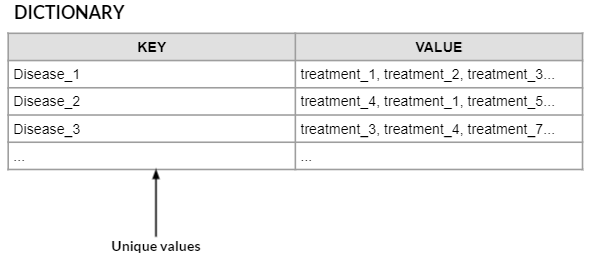

In [29]:
disease_list=[] # list of  disease in a sentence
treatment_list=[]# list of all treatments in a sentence
for i,labels in enumerate(Y_pred):
    disease=""
    treatment=""
    for j,label in enumerate(labels):
        if label=='O':
            continue
        if label=='D':
            disease+= str(all_test_sentence[i].split()[j].lower()) + " "
            pass
        if label=='T':
            treatment+= str(all_test_sentence[i].split()[j].lower()) + " "
            pass
    if disease!="":# ie. if disease is empty than re run loop
        disease_list.append(disease)  
        treatment_list.append(treatment)

In [30]:
#for i,labels in enumerate(Y_pred):
    #for j,label in enumerate(labels):
        #print('i=',i,'j=',j,all_test_sentence[i].split()[j], label)

In [31]:
#Lets define a dataframe with disease and treatments
disease_treatment=pd.DataFrame({'Disease':disease_list, 'Treatment':treatment_list} )
#removing empty treatment columns i.e. sentences which do not have mention of treatment
disease_treatment= disease_treatment[disease_treatment['Treatment']!=''].reset_index()
#dropping index column
disease_treatment.drop('index', axis=1, inplace=True)
disease_treatment.head()

,Disease,Treatment
0,hereditary retinoblastoma,radiotherapy
1,myocardial infarction,"mg aspirin , 3 mg warfarin with 80 mg aspirin ..."
2,unstable angina or non-q-wave myocardial infar...,roxithromycin
3,primary pulmonary hypertension ( pph ),fenfluramines
4,foot infection,g-csf treatment


In [32]:
#shape of dataset diseases and treatment
disease_treatment.shape

(104, 2)

In [33]:
#aggregating diseases with same names by groupby and treatments with ','
disease_treatment=disease_treatment.groupby('Disease', as_index=False).agg({'Disease':'first','Treatment':', '.join})

In [34]:
#shape of data after dataset 
disease_treatment.shape

(99, 2)

In [35]:
#final disease datbase in required format
disease_treatment.head()

,Disease,Treatment
0,abdominal pain,thoracic paravertebral block ( tpvb )
1,abdominal tuberculosis,steroids
2,acoustic neuroma,stereotactic radiosurgery
3,acute cerebral ischemia,antiplatelet therapy
4,acute myocardial infarction,thrombolytic therapy


### Predicting the treatment for the disease name: 'hereditary retinoblastoma'

In [36]:
print("Treatment of Hereditary Retinoblastoma is", disease_treatment
      [disease_treatment['Disease']=='hereditary retinoblastoma ']['Treatment'][38].upper())

Treatment of Hereditary Retinoblastoma is RADIOTHERAPY 



We can use other features like whether there is any special charcter between word, digit between words etc. while defining features to get more accuracy in predicting correct diseases and treatments

********************************************End****************************************************